# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd
from liesel.contrib import splines

import liesel_gam as gam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

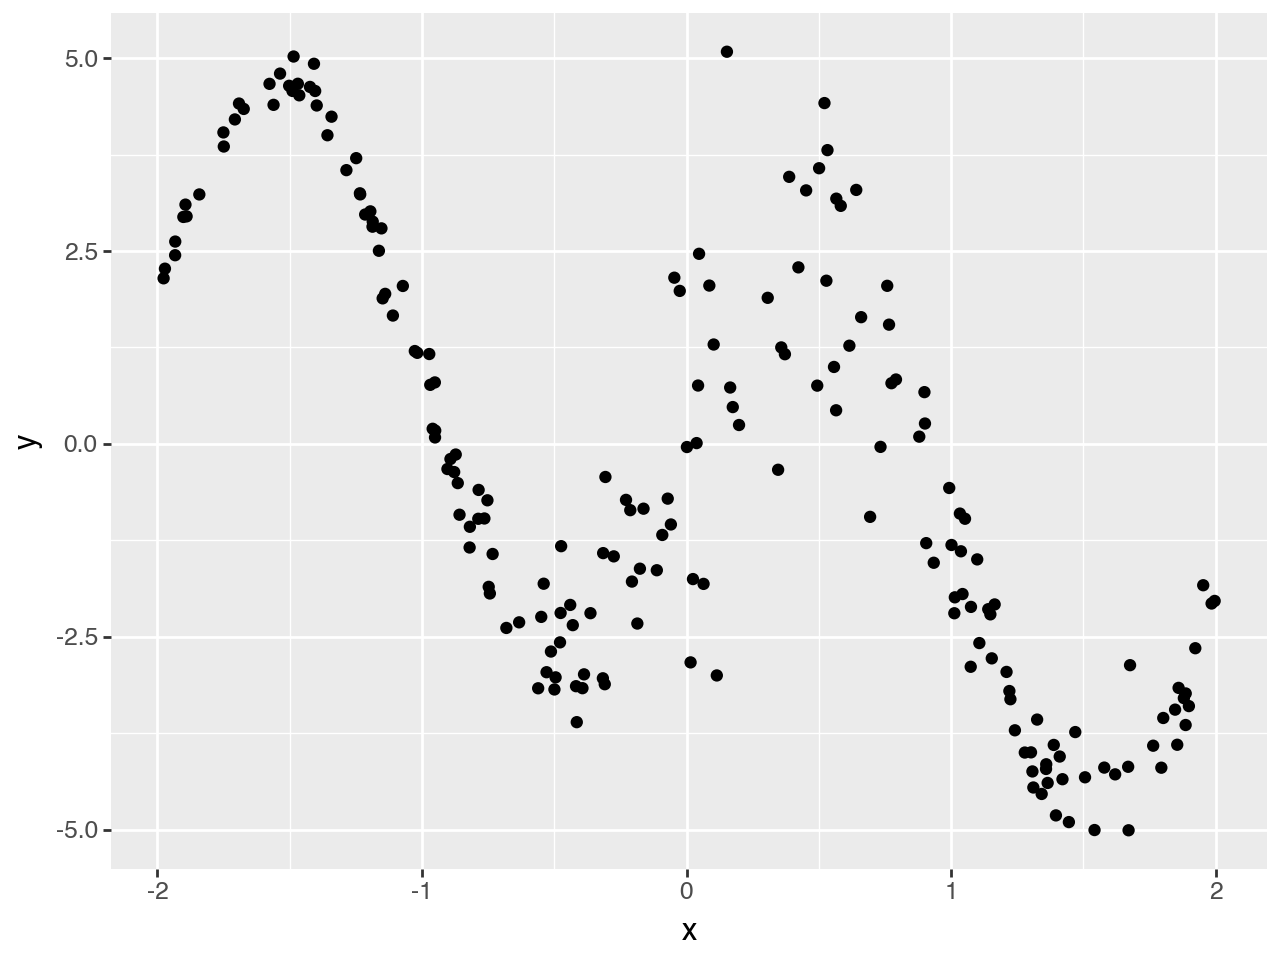

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

The `gam.AdditivePredictor()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [4]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

### Set up basis an penalty matrices

Here, we set up a very simple B-spline basis matrix and corresponding penalty matrix.
Since we do not add any additional constraints, we do not include any additional
intercepts in the model. In practice, you probably want to use 
[smoothcon](https://github.com/liesel-devs/smoothcon) to pull your penalty matrices
directly from the R package `mgcv`. These will be properly equipped with sum-to-zero
constraints from the start.

In [5]:
knots = splines.equidistant_knots(df.x.to_numpy(), n_param=20, order=3)
basis = splines.basis_matrix(x, knots, order=3)
penalty = splines.pspline_penalty(d=basis.shape[-1], diff=2)

### Initialize smooth terms

The `gam.SmoothTerm` can be used to represent isotropic smooths. It is a `lsl.Var` that
will automatically initialize a fitting coefficient variabel with a 
potentially singular multivariate normal prior given the penalty matrix.

In [6]:
# we use the same basis for both smooths here
x_basis = gam.Basis(basis, name="B(x)")

loc += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="m(x)",
    variance_name="$\\tau^2_m$",
    coef_name="$\\beta$",  # I'm using LaTeX math syntax for pretty rendering in plots
)

scale += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="s(x)",
    variance_name="$\\tau^2_s$",
    coef_name="$\\gamma$",
)

### Build and plot model

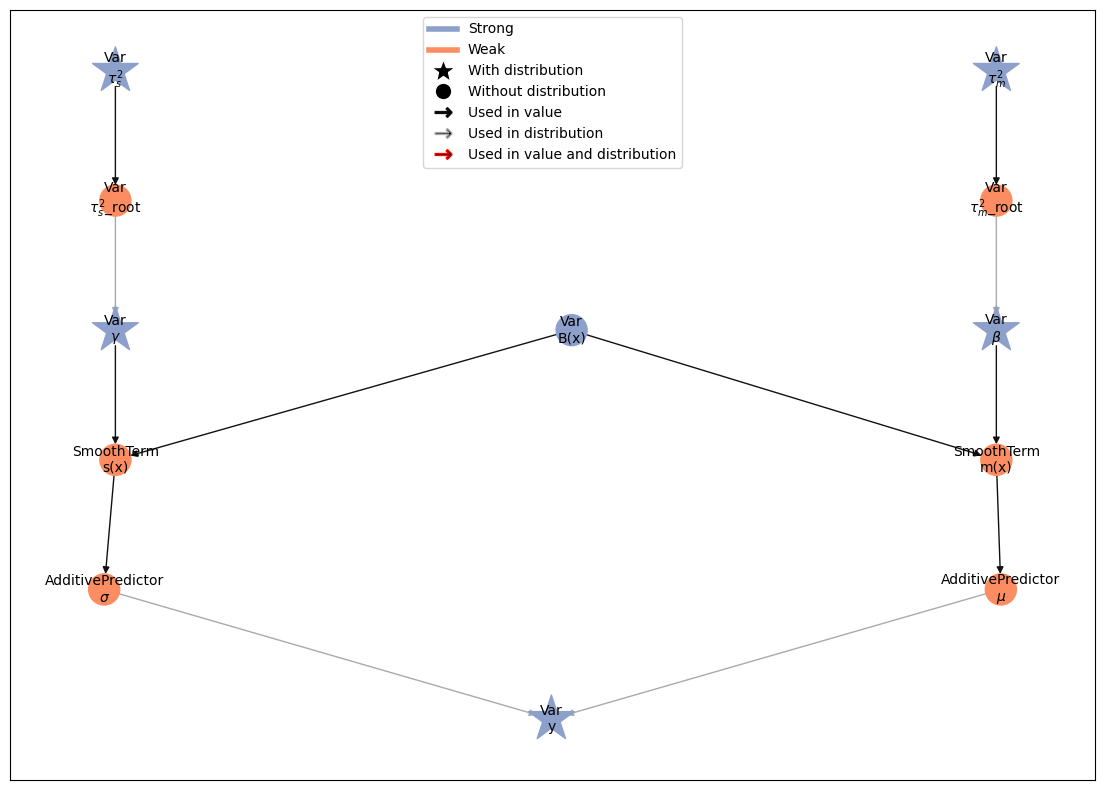

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\gamma$', '$\\tau^2_s$', '$\\beta$', '$\\tau^2_m$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  5.93chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 174.19chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 179.72chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATIO

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                     kernel      mean        sd    q_0.05     q_0.5    q_0.95  \
parameter  index                                                                
$\beta$    (0,)   kernel_02 -0.573275  0.906977 -2.025462 -0.583405  0.911432   
           (1,)   kernel_02  2.130786  0.161269  1.868156  2.135068  2.393054   
           (2,)   kernel_02  4.047431  0.118948  3.851841  4.046777  4.246058   
           (3,)   kernel_02  5.075792  0.119487  4.881212  5.074934  5.269836   
           (4,)   kernel_02  4.026021  0.147037  3.778093  4.025819  4.263738   
           (5,)   kernel_02  1.341294  0.171165  1.056191  1.340625  1.616476   
           (6,)   kernel_02 -0.981388  0.187570 -1.290720 -0.982578 -0.666545   
           (7,)   kernel_02 -2.801121  0.267712 -3.234217 -2.798776 -2.362588   
           (8,)   kernel_02 -2.546239  0.312544 -3.056231 -2.547397 -2.021316   
           (9,)   kernel_02 -0.863724  0.426755 -1.562312 -0.857517 -0.179860   
           (10,)  kernel_02  0.861446  0.503246  0.044984  0.867443  1.693374   
           (11,)  kernel_02  2.237089  0.523108  1.371679  2.237962  3.070138   
           (12,)  kernel_02  2.239183  0.423903  1.540914  2.238991  2.934969   
           (13,)  kernel_02  0.372642  0.358277 -0.216764  0.377382  0.958228   
           (14,)  kernel_02 -1.871064  0.245292 -2.261036 -1.874025 -1.465509   
           (15,)  kernel_02 -4.282661  0.219648 -4.645925 -4.282893 -3.932234   
           (16,)  kernel_02 -4.583643  0.261178 -5.006065 -4.586088 -4.147029   
           (17,)  kernel_02 -4.133153  0.272193 -4.581239 -4.138080 -3.688750   
           (18,)  kernel_02 -2.028649  0.325174 -2.556027 -2.028276 -1.507955   
           (19,)  kernel_02  0.861834  1.464464 -1.593912  0.881729  3.169068   
$\gamma$   (0,)   kernel_00 -2.646173  0.624710 -3.638580 -2.661126 -1.605139   
           (1,)   kernel_00 -2.342050  0.306659 -2.817114 -2.352221 -1.815493   
           (2,)   kernel_00 -2.042364  0.200633 -2.360524 -2.046562 -1.705927   
           (3,)   kernel_00 -1.733754  0.177474 -2.012168 -1.741471 -1.429663   
           (4,)   kernel_00 -1.464864  0.161599 -1.714628 -1.471651 -1.187949   
           (5,)   kernel_00 -1.211015  0.149467 -1.443908 -1.215499 -0.954550   
           (6,)   kernel_00 -0.956292  0.153704 -1.213086 -0.958309 -0.703195   
           (7,)   kernel_00 -0.599326  0.160609 -0.864100 -0.599526 -0.343087   
           (8,)   kernel_00 -0.157551  0.159707 -0.417219 -0.155741  0.102618   
           (9,)   kernel_00  0.304927  0.154814  0.059366  0.299425  0.561995   
           (10,)  kernel_00  0.618132  0.157726  0.373236  0.608686  0.892939   
           (11,)  kernel_00  0.551073  0.170708  0.278207  0.548183  0.836845   
           (12,)  kernel_00  0.279220  0.158664  0.027085  0.274525  0.547402   
           (13,)  kernel_00 -0.138601  0.157181 -0.392135 -0.140656  0.114340   
           (14,)  kernel_00 -0.563130  0.157658 -0.817759 -0.561421 -0.303757   
           (15,)  kernel_00 -0.819785  0.178705 -1.112972 -0.815969 -0.530014   
           (16,)  kernel_00 -0.778292  0.166588 -1.031835 -0.788359 -0.484823   
           (17,)  kernel_00 -0.770430  0.183571 -1.046780 -0.787724 -0.440781   
           (18,)  kernel_00 -0.882171  0.324207 -1.384765 -0.897543 -0.333752   
           (19,)  kernel_00 -1.003071  0.666770 -2.081284 -0.996869  0.094476   
$\tau^2_m$ ()     kernel_03  2.766837  1.256541  1.336869  2.501342  5.157987   
$\tau^2_s$ ()     kernel_01  0.109018  0.109946  0.025003  0.078795  0.282630   

                  sample_size     ess_bulk     ess_tail      rhat  
parameter  index                                                   
$\beta$    (0,)          4000  3201.340341  3405.973346  1.001258  
           (1,)          4000  3298.788645  3629.388815  1.000579  
           (2,)          4000  3320.017839  3775.346255  1.000984  
           (3,)          4000  3256.045862  3538.173299  1.001210  
       

### MCMC trace plots

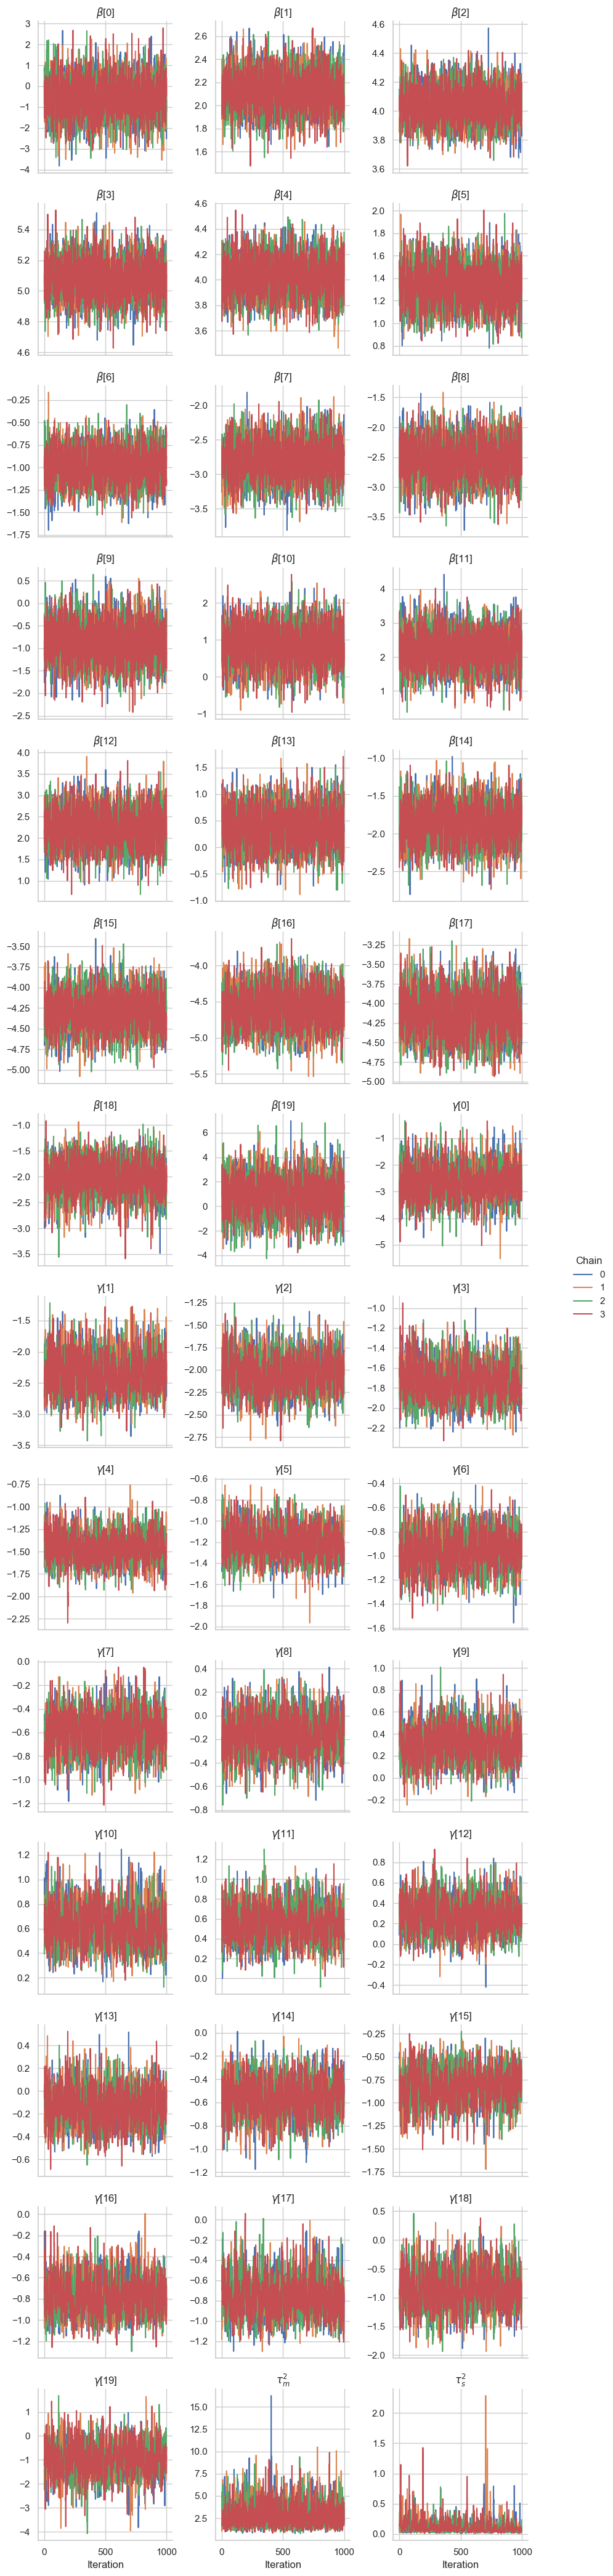

In [10]:
gs.plot_trace(results)

## Predictions

In [11]:
samples = results.get_posterior_samples()

### Evaluate basis matrix for new x values

In [12]:
x_grid = jnp.linspace(x.min(), x.max(), 200)
B_x_grid = splines.basis_matrix(x=x_grid, knots=knots, order=3)

### Predict variables at new x values

In [13]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "s(x)", "$\\mu$", "$\\sigma$"],
    newdata={"B(x)": B_x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [14]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.191189,0.004247,0.065172,1.000952,3349.834392,3087.115184,0.001128,0.000934,2.085066,2.189397,2.299698,2.077750,2.291252,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.378109,0.002460,0.049596,1.000293,3439.825882,3431.766730,0.000848,0.000706,2.299133,2.377298,2.457439,2.299691,2.457566,-1.956738
2,$\mu$,$\mu$[2],"(2,)",4000,2.559273,0.001856,0.043081,1.000056,3486.025933,3621.476361,0.000731,0.000608,2.488844,2.559090,2.629963,2.482374,2.623127,-1.936774
3,$\mu$,$\mu$[3],"(3,)",4000,2.734621,0.001787,0.042268,1.000402,3505.205936,3665.459073,0.000715,0.000581,2.665112,2.734957,2.802398,2.663609,2.800491,-1.916810
4,$\mu$,$\mu$[4],"(4,)",4000,2.904096,0.001902,0.043610,1.000478,3505.501776,3693.751708,0.000737,0.000583,2.831355,2.904716,2.974743,2.833790,2.976091,-1.896846


### Plot fitted functions

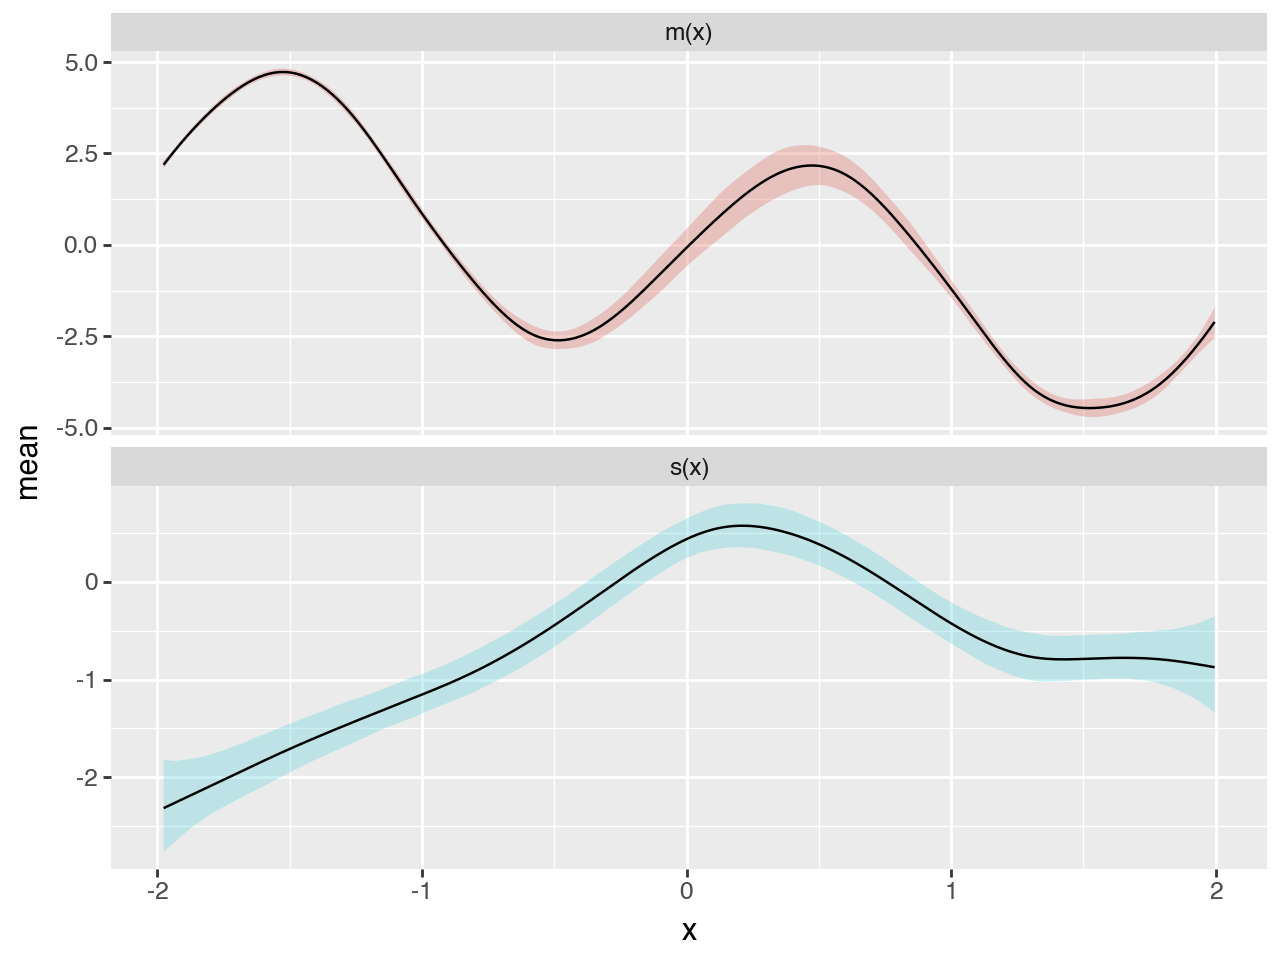

In [16]:
select = predictions_summary["variable"].isin(["s(x)", "m(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

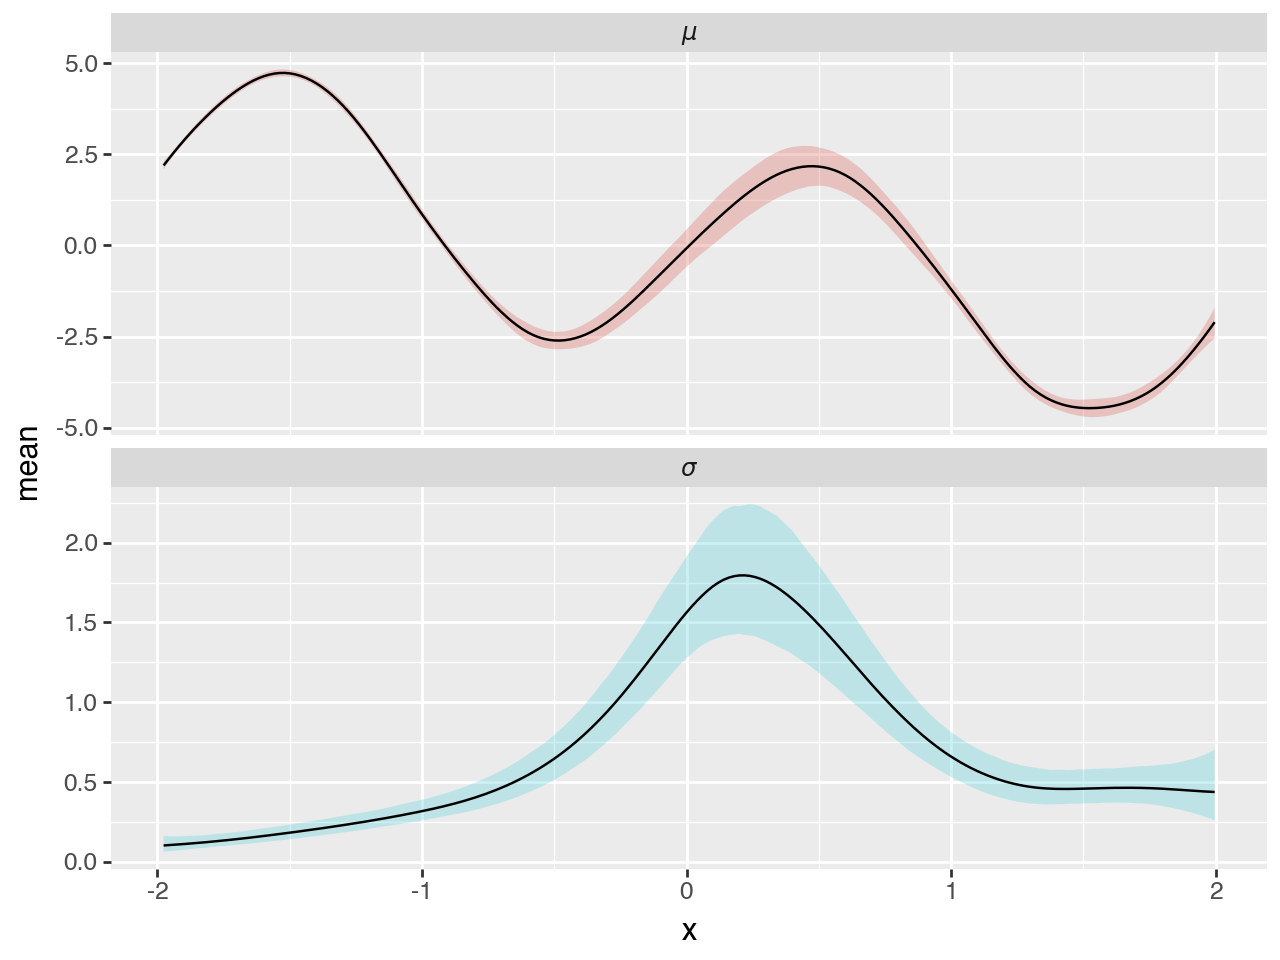

In [18]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

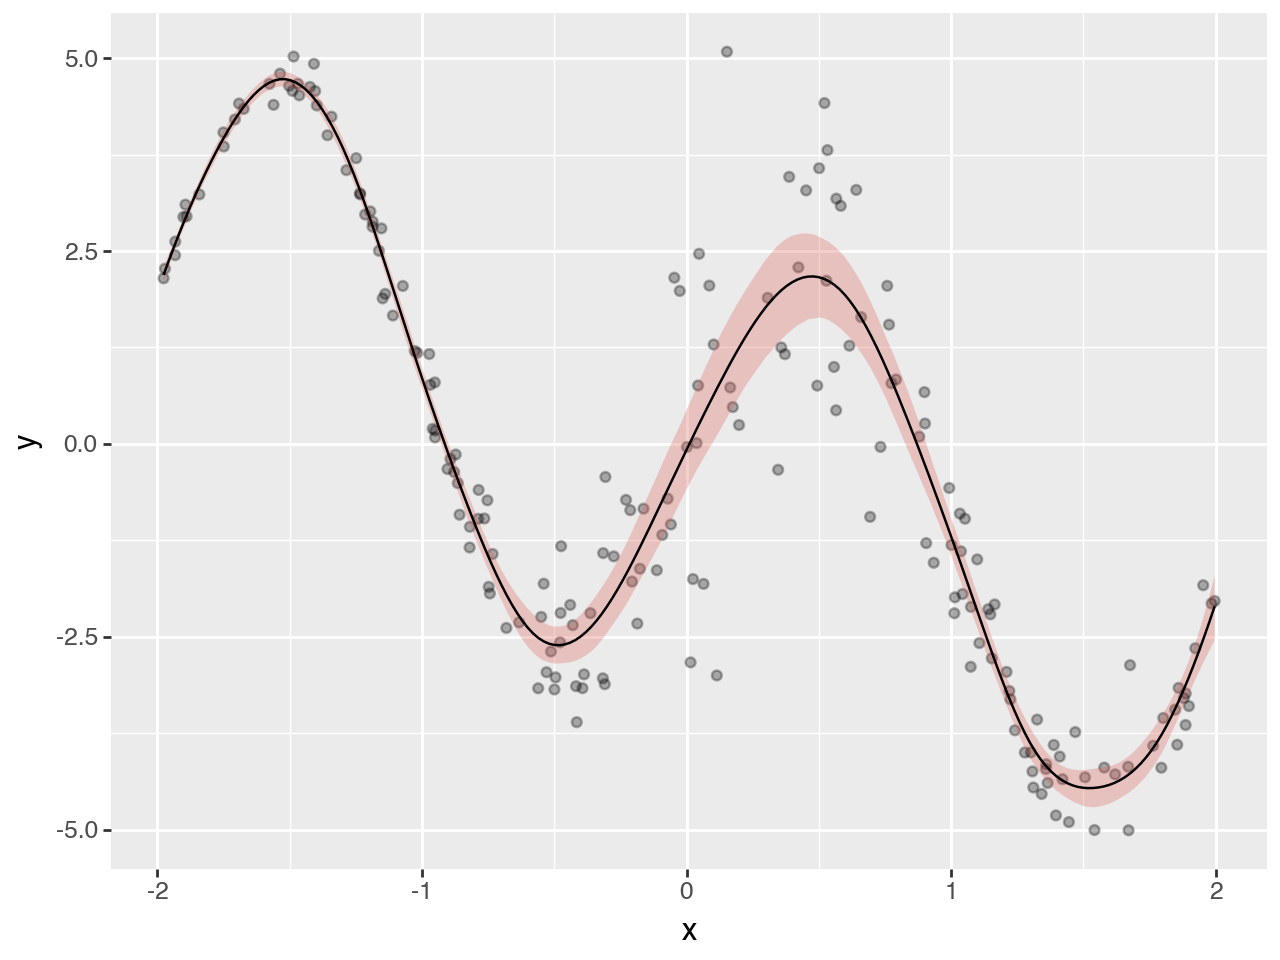

In [21]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [22]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.191189,0.102864,2.088325,2.294053
1,-1.956738,2.378109,0.105005,2.273104,2.483113
2,-1.936774,2.559273,0.107260,2.452014,2.666533
3,-1.916810,2.734621,0.109629,2.624992,2.844249
4,-1.896846,2.904096,0.112112,2.791983,3.016208
...,...,...,...,...,...
195,1.916248,-2.871750,0.445454,-3.317204,-2.426296
196,1.936212,-2.691114,0.443286,-3.134399,-2.247828
197,1.956176,-2.502755,0.441267,-2.944022,-2.061489
198,1.976140,-2.307200,0.439454,-2.746653,-1.867746


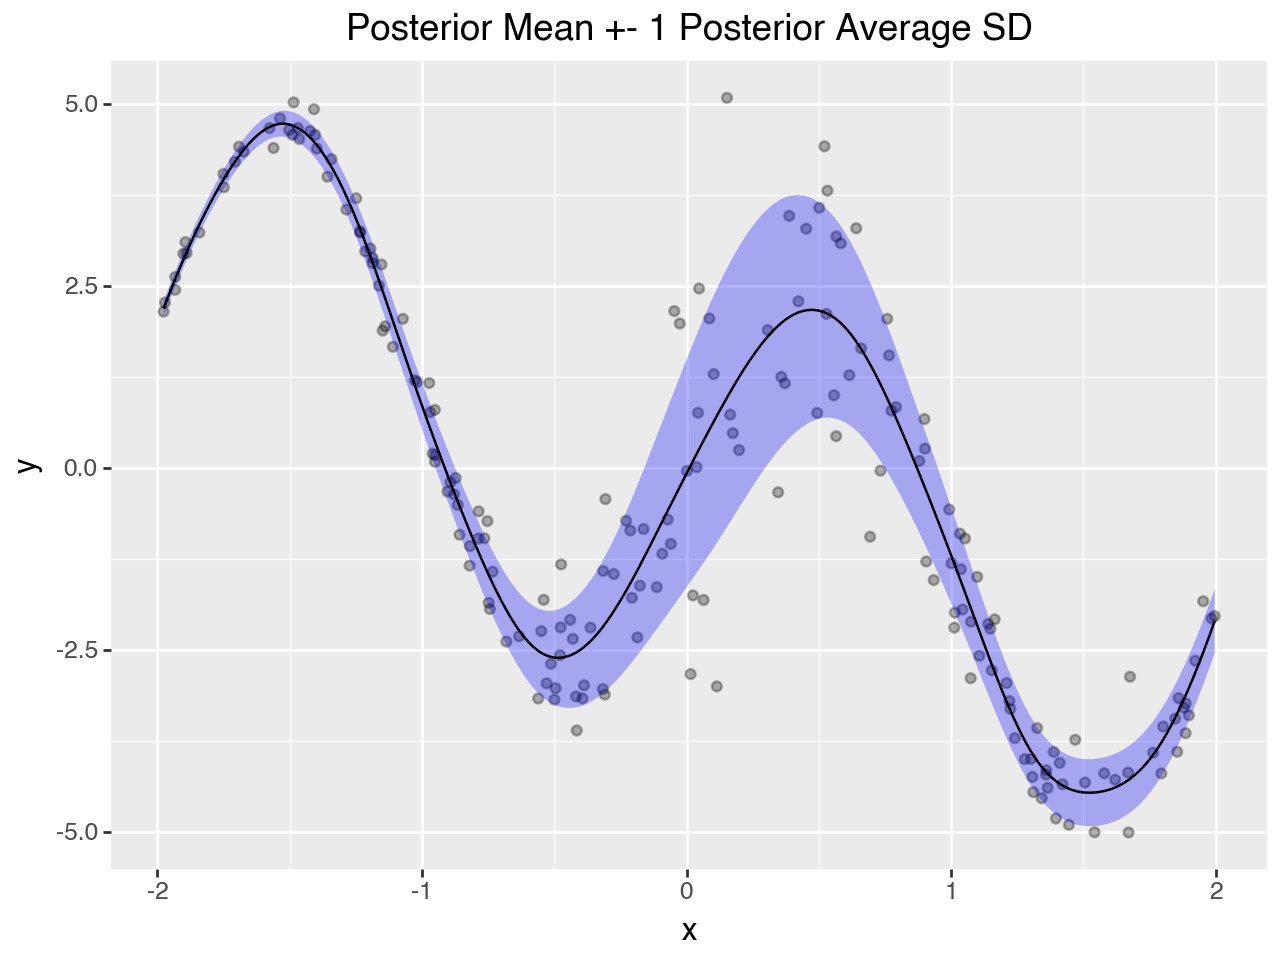

In [24]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [25]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [26]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [27]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

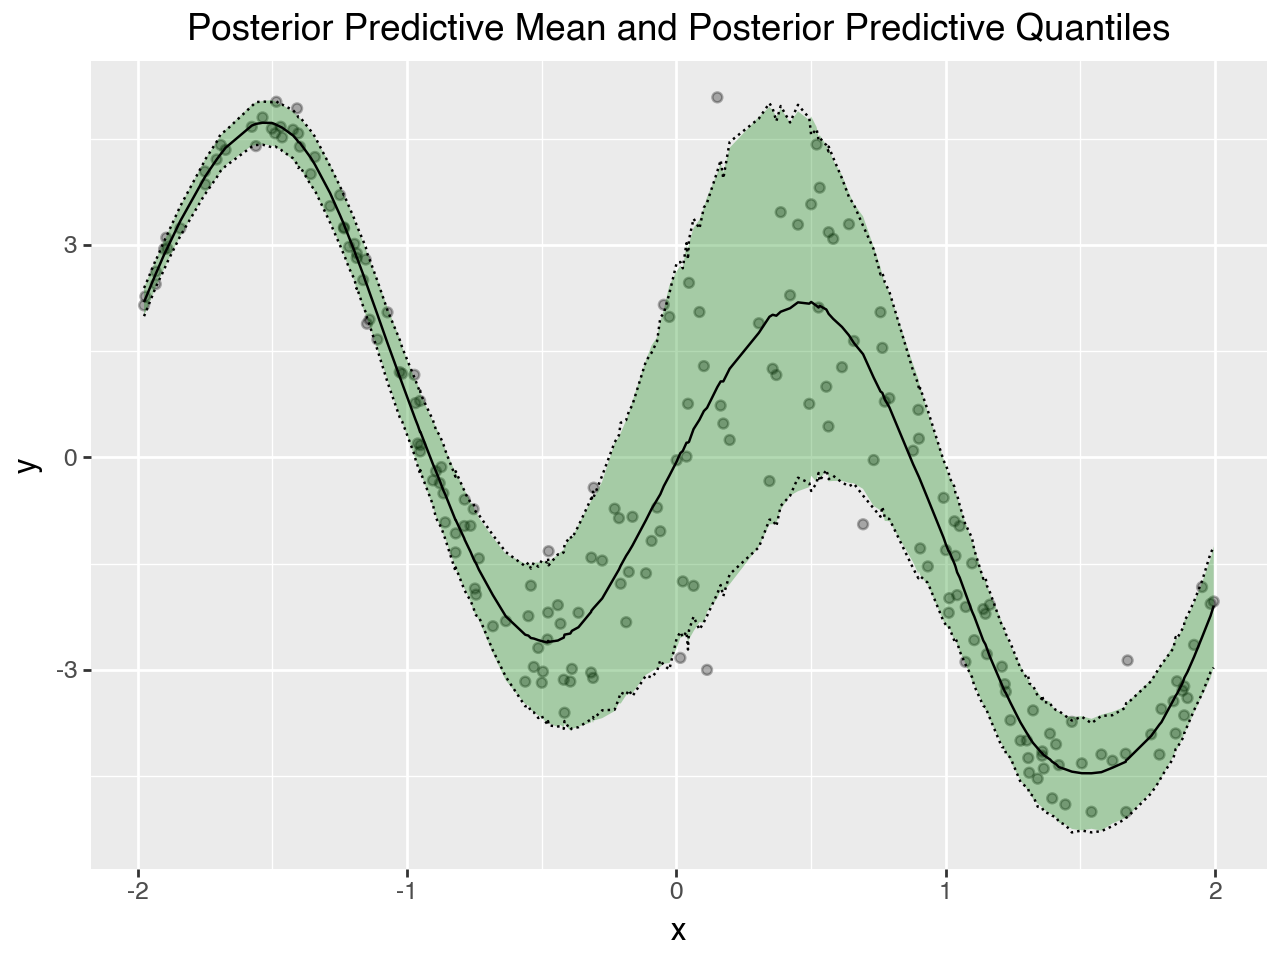

In [28]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

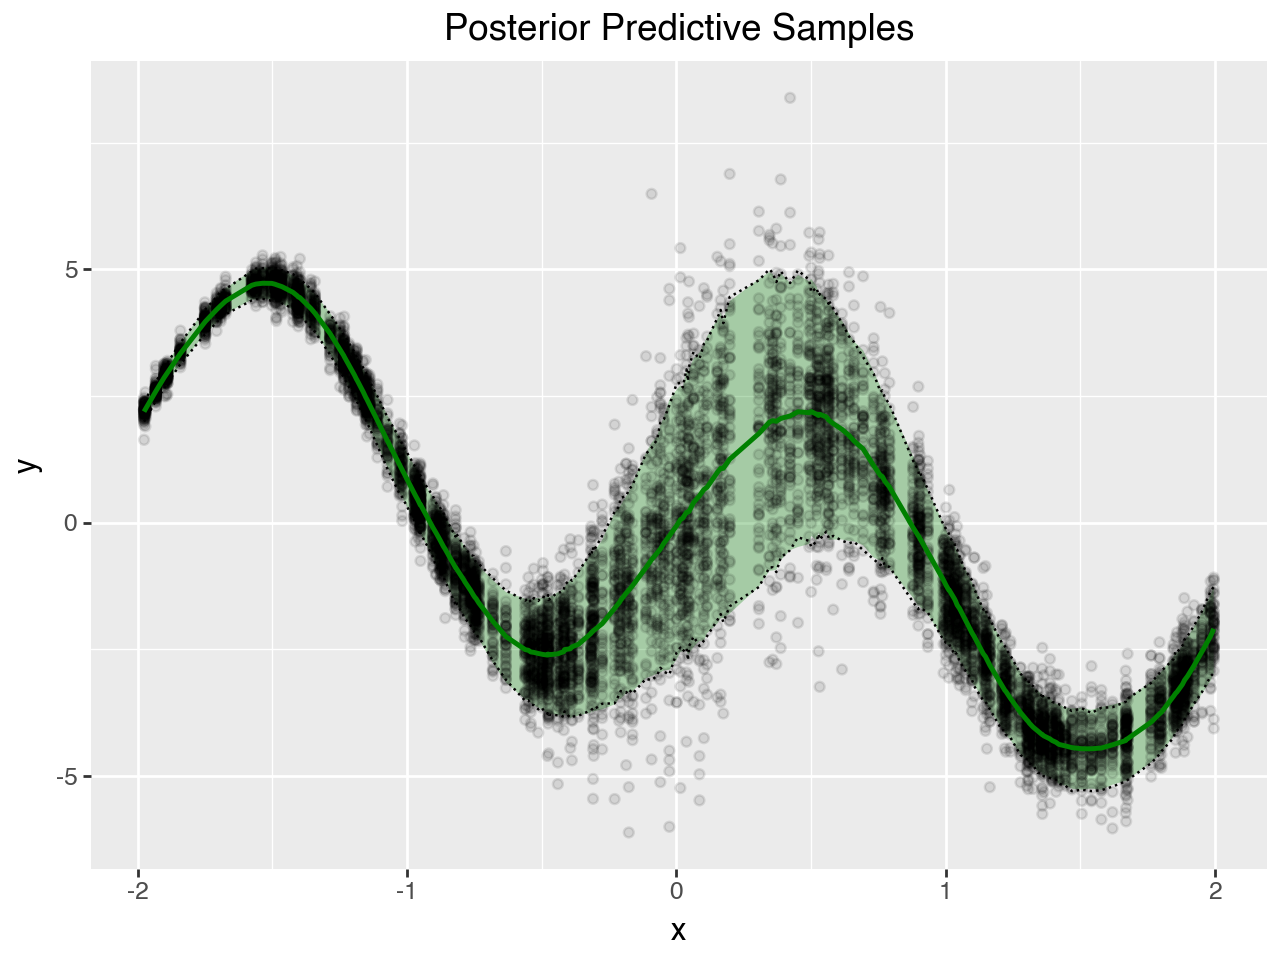

In [29]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)